In [1]:
import os
from pathlib import Path 
import sys
import matplotlib.pyplot as plt
# sys.path.append('../../dataset')
sys.path.append('/home/kirilman/Project/asbestos/')
from dataset.path_utils import get_paths_from_dirs
sys.path.append("/home/kirilman/Project/asbestos/JSON2YOLO")

from general_json2yolo import convert_coco_json
import shutil
import json
import numpy as np
import cv2

In [2]:
sys.path

['/home/kirilman/Project/asbestos/notebooks/dataloader',
 '/home/kirilman/miniconda3/lib/python39.zip',
 '/home/kirilman/miniconda3/lib/python3.9',
 '/home/kirilman/miniconda3/lib/python3.9/lib-dynload',
 '',
 '/home/kirilman/miniconda3/lib/python3.9/site-packages',
 '/home/kirilman/Project/asbestos/',
 '/home/kirilman/Project/asbestos/JSON2YOLO']

In [4]:
datasets_names = ['pits_stones_detections_020221',
                  'pits_stones_detections_161120',
                  'pits_stones_detections_111121',
                  'pits_stones_detections_161220',
                  'pits_stones_detections_300920',
                  'asbestos_stone_020221',
                  'open-pit-zoomed-161120',
                  'asbest_stones_111121',
                  'test transport',
                  'asbestos_stone_161220']

In [14]:
def is_file_image(p:Path):
    return p.suffix.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))

In [281]:
root_to_dataset = Path('/home/kirilman/Project/dataset')
images_paths = []
for data_set in datasets_names:
    p = (root_to_dataset / data_set).resolve()
    r = Path(p).resolve().rglob('*.*')
    for e in r:
        if is_file_image(e):
            images_paths.append(e)
            
len(images_paths)

394

### Скопировать изображения

In [247]:
images_files = []
for data_set in datasets_names:
    p = (root_to_dataset / data_set).resolve()
    r = get_paths_from_dirs([p], ['*'])
    for e in r:
        if is_file_image(e):
            images_files+=[e]

path_2_detection_set = Path('/home/kirilman/Project/dataset/detection_set2/images')
if path_2_detection_set.exists():
    shutil.rmtree(path_2_detection_set)
    path_2_detection_set.mkdir(parents=True,exist_ok=True)
else:
    path_2_detection_set.mkdir(parents=True,exist_ok=True)

#скопировать
for p in images_files:
    shutil.copyfile(p, path_2_detection_set / p.name)

### Скопировать json файлы с разметкой

In [242]:
labels_files = []
for data_set in datasets_names:
    p = (root_to_dataset / data_set).resolve()
    r = get_paths_from_dirs([p], ['json'])
    for e in r:
        labels_files+=[e]

path_2_labels = Path('/home/kirilman/Project/dataset/detection_set2/labels')
if path_2_labels.exists():
    shutil.rmtree(path_2_labels)
    path_2_labels.mkdir(parents=True,exist_ok=True)
else:
    path_2_labels.mkdir(parents=True,exist_ok=True)

#скопировать
for p in labels_files:
    shutil.copyfile(p, path_2_labels / (p.parent.parts[-2] + p.suffix))

In [267]:
#фикс путь до изображений
for label_file in get_paths_from_dirs([path_2_labels], ['json']):
    f = open(label_file)
    data = json.load(f)
    f.close()
    
    for i, im in enumerate(data['images']):
        p = Path(im['file_name'])
        data['images'][i]['file_name'] = p.name
        
        with open(f.name, 'w') as outfile:
            json.dump(data, outfile)

In [277]:
### Convert to yolo

In [315]:
path_2_labels = '/home/kirilman/Project/dataset/detection_set2/coco_labels/' 
json_files = get_paths_from_dirs([path_2_labels], ['json'])
path_to_yolo = '/home/kirilman/Project/dataset/detection_set2/labels/'
convert_coco_json(json_files[0].parent, path_to_yolo)

Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/asbest_sto
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/asbestos_s
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/asbestos_s
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/open-pit-z
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/pits_stone
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/pits_stone
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/pits_stone
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/pits_stone
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/pits_stone
Annotations /home/kirilman/Project/dataset/detection_set2/coco_labels/test trans


In [316]:
json_files = get_paths_from_dirs([path_to_yolo], ['txt'])
len(json_files)
for f in json_files:
    shutil.copy(f, path_to_yolo)

In [11]:
json_files = get_paths_from_dirs([path_to_yolo], ['txt'])
images_files = get_paths_from_dirs([path_2_detection_set], ['*'])
print(len(json_files), len(images_files))

NameError: name 'path_to_yolo' is not defined

In [305]:
##DELETE Asbests bboxs

In [334]:
path_2_yolo = Path('/home/kirilman/Project/dataset/detection_set2/labels/rocks and asbest/')
yolo_files = os.listdir(path_2_yolo)
for name in yolo_files:
    outfile = open(path_2_yolo.parent / name, "w")
    file = open(path_2_yolo / name, 'r') 
    lines = file.readlines()
    for line in lines:
        if line in lines:
            if line[0] == "1":
                continue
            else:
                outfile.write(line)
    outfile.close()
    file.close()

### Разбиение на обучение тест

In [1]:
image_files = get_paths_from_dirs(['/home/kirilman/Project/dataset/detection_set2/images/'], ['*'])
label_files = get_paths_from_dirs(['/home/kirilman/Project/dataset/detection_set2/labels/'], ['*'])

print("Всего изображений: ", len(image_files))
N = len(image_files)
K = round(0.25 * N)

print("Тест + Валидация: ",K)
indexs = np.random.choice(range(N), K)

test_indexs = indexs[:-20]
val_indexs  = indexs[-20:]
print("Tecт         ",len(test_indexs))
print("Валидация    ", len(val_indexs))

NameError: name 'get_paths_from_dirs' is not defined

In [1]:
394-78-20

296

In [72]:
def img2label_paths(img_paths):
    # Define label paths as a function of image paths
    sa, sb = f'{os.sep}images{os.sep}', f'{os.sep}labels{os.sep}'  # /images/, /labels/ substrings
    return [sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0] + '.txt' for x in img_paths]

In [82]:
path_2_images = image_files[0].parent
path_2_validation = path_2_images.parent / 'validation'
path_2_test       = path_2_images.parent / 'test'
path_2_train       = path_2_images.parent / 'train'
def create_folder(path):
    if path.exists():
        shutil.rmtree(path)
        path.mkdir(parents=True,exist_ok=True)
    else:
        path.mkdir(parents=True,exist_ok=True)
    
create_folder(path_2_validation)
create_folder(path_2_test)
create_folder(path_2_train / "images")
create_folder(path_2_train / "labels")

In [84]:
#копируем файлы
#тестовые
for path_image in [p for i,p in enumerate(image_files) if i in test_indexs]:
    path_label = img2label_paths([str(path_image)])[0]
    shutil.copy(path_image, path_2_test / path_image.name)
    shutil.copy(path_label, path_2_test / Path(path_image.name.split('.')[0] + '.txt') )

#Валидация

for path_image in [p for i,p in enumerate(image_files) if i in val_indexs]:
    path_label = img2label_paths([str(path_image)])[0]
    shutil.copy(path_image, path_2_validation / path_image.name)
    shutil.copy(path_label, path_2_validation / Path(path_image.name.split('.')[0] + '.txt') )


In [80]:
train_indexs = np.array(list(set(range(N)) - set(indexs)))

In [83]:
for path_image in [p for i,p in enumerate(image_files) if i in train_indexs]:
    path_label = img2label_paths([str(path_image)])[0]
    shutil.copy(path_image, path_2_train / "images" / path_image.name)
    shutil.copy(path_label, path_2_train / "labels" / Path(path_image.name.split('.')[0] + '.txt') )

#### 270421

In [11]:
from preprossesing import resize_images
resize_images(['/home/kirilman/Project/dataset/270421'],
              ["*"],"/home/kirilman/Project/dataset/270421_resize", (720,720), {})

In [2]:
### Cлить разметку

In [77]:
path_2_pred_labels = "/home/kirilman/Project/asbestos/yolov5/runs/detect/exp10/labels"
predict_files = get_paths_from_dirs([path_2_pred_labels], ['txt'])
print(len(predict_files))

predict_labels = {}
for p in predict_files:
    f = open(p,'r')
    lines = f.readlines()
    f.close()
    predict_labels[p.name] = lines

308


In [78]:
train_files = get_paths_from_dirs(['/home/kirilman/Project/dataset/detection_set2/train/labels'], ['txt'])
train_labels = {}
for p in train_files:
    f = open(p,'r')
    lines = f.readlines()
    f.close()
    train_labels[p.name] = lines

In [90]:
save_dir = Path('/home/kirilman/Project/dataset/detection_set2/train_merge/labels/')
for k,label in train_labels.items():
    pred_label = predict_labels[k]
    merge = label + pred_label
    r = np.genfromtxt(merge)
    np.savetxt(save_dir / k, r)

637412002540099552.txt


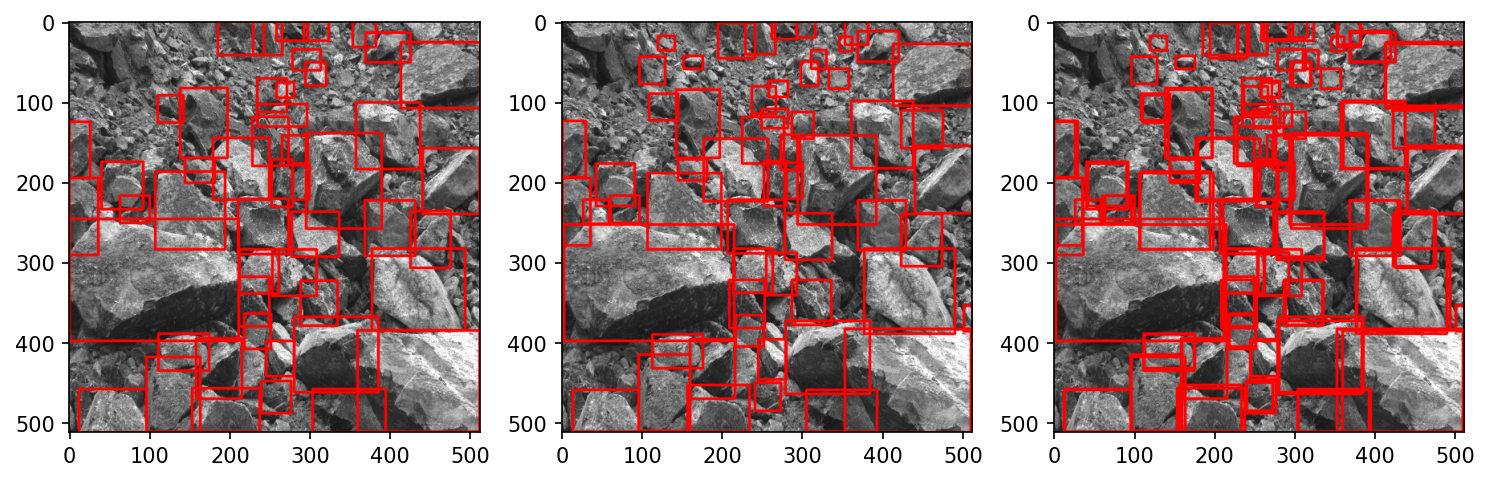

In [102]:
from tools.plots import plot_bboxs
sys.path.append("/home/kirilman/Project/asbestos/yolov5")
from yolov5.utils.general import xywhn2xyxy, xywh2xyxy

file_name  = predict_files[128].name
print(file_name)
img_source = cv2.imread(str(Path("/home/kirilman/Project/dataset/detection_set2/train/images") / file_name.replace('txt','bmp')))
img_source = cv2.resize(img_source,(512,512))
img7 = plot_bboxs(img_source.copy(),     xywh2xyxy(np.genfromtxt(train_labels[file_name])[:,1:]), line_thickness = 2)
img_pred = plot_bboxs(img_source.copy(), xywh2xyxy(np.genfromtxt(predict_labels[file_name])[:,1:]), line_thickness = 2)
img_merge = plot_bboxs(img_source.copy(), 
            xywh2xyxy(np.loadtxt(Path("/home/kirilman/Project/dataset/detection_set2/train_merge/labels") / file_name)[:,1:]),line_thickness = 2)

fig,ax = plt.subplots(1,3,dpi = 150, figsize=(12,7))
ax[0].imshow(img7)
ax[1].imshow(img_pred)
ax[2].imshow(img_merge)